<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/DL_TL_dogs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io,os
import numpy as np
import pandas as pd

In [2]:
import json

In [3]:
kaggle_json = {"username":"twyiweilin","key":"58a1caf3d6bee0e188c5978f4763ea4d"}

In [4]:
os.makedirs('/content/.kaggle/',exist_ok=True)

In [5]:
os.makedirs('/root/.kaggle/',exist_ok=True)

In [6]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(kaggle_json, file)

In [7]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c dogs-vs-cats

 96% 260M/271M [00:02<00:00, 133MB/s]
100% 271M/271M [00:02<00:00, 102MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 78.2MB/s]
 98% 533M/543M [00:03<00:00, 196MB/s]
100% 543M/543M [00:03<00:00, 168MB/s]


In [9]:
!unzip /content/train.zip
!unzip /content/test1.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           
  inflating: test1/5520.jpg  

In [10]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(244,244,3)) #不包括大腦 / 偷來的 model 設計是224
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
______________________________________________________________

In [11]:
import glob
import pandas as pd
# 先不讀取圖片, 真的要訓練才讀
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("train/cat.*.jpg"):
  s = pd.Series([p, 0], index=["path", "target"])
  df = df.append(s, ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
  s = pd.Series([p, 1], index=["path", "target"])
  df = df.append(s, ignore_index=True)
df

,path,target
0,train/cat.325.jpg,0
1,train/cat.10274.jpg,0
2,train/cat.5012.jpg,0
3,train/cat.10344.jpg,0
4,train/cat.6197.jpg,0
...,...,...
24995,train/dog.10820.jpg,1
24996,train/dog.2193.jpg,1
24997,train/dog.6731.jpg,1
24998,train/dog.2254.jpg,1


train/dog.7609.jpg
(299, 262)


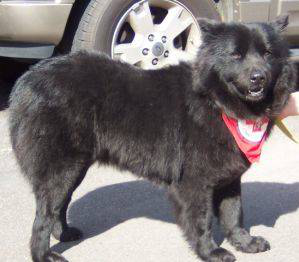

In [19]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

In [ ]:
img = load_img(df["path"][c], target_size=(224,224))
print(img.size)
img

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten
vgg